# Model Prediksi Sentimen pada Ulasan Film Menggunakan Natural Language Processing  <a id='intro'></a>

Sebuah perusahaan hiburan ingin membuat sebuah model `machine learning` untuk menyaring ulasan-ulasan sebuah `film` serta mengkategorikanya. Ulasan-ulasan tersebut harus bisa dikenali apakah berupa `ulasan positf` atau `ulasan negatif`. Kita akan menggunakan `dataset` ulasan dari `IMDB` dengan `pelabelan polaritas` untuk membuat sebuah model yang bisa mengklasifikasikan `ulasan positif` dan `negatif`. Model ini setidaknya harus memiliki skor `F1` sebesar` 0,85`. Dataset akan kita lakukan eksplorasi menggunakan `analisis data eksploratif (EDA)` untuk mendapatkan `insights` di dalamnya serta memastikan agar `dataset` bisa melatih model dengan baik. Beberapa `model` dengan `konfigurasi`-nya yang akan kita latih dan uji diantaranya:
- Model 0 - Konstan (*Dummy Classifier*)
- Model 1 - NLTK, TF-IDF dan *Logistic Regression*
- Model 2 - spaCy, TF-IDF dan *Logistic Regression*
- Model 3 - spaCy, TF-IDF dan LGBMClassifier
- Model 4 - BERT (*Bidirectional Encoder Representations from Transformers*) dan *Logistic Regression*

# Konten <a id='back'></a>

* [Pendahuluan](#intro)
* [Konten](#back)
* [Tahap 1. Inisialisasi](#cont_1)
* [Tahap 2. Memuat Data](#cont_2)
* [Tahap 3. Analisis Data Eksploratif (EDA)](#cont_3)
* [Tahap 4. Prosedur Evaluasi](#cont_4)
* [Tahap 5. Normalisasi](#cont_5)
* [Tahap 6. Pemisahan Train / Test](#cont_6)
* [Tahap 7. Bekerja dengan Model](#cont_7)
    * [7.1 Model 0 - Konstan](#cont_8) 
    * [7.2 Model 1 - NLTK, TF-IDF dan LR](#cont_9) 
    * [7.3 Model 2 - spaCy, TF-IDF dan LR](#cont_10) 
    * [7.4 Model 3 - spaCy, TF-IDF dan LGBMClassifier](#cont_11) 
    * [7.5 Model 4 - BERT (Bidirectional Encoder Representations from Transformers) dan LR](#cont_12) 
        * [7.5.1 Jumlah Sampel Kecil](#cont_13) 
        * [7.5.2 Jumlah Sampel Besar](#cont_14) 
* [Tahap 8. Ulasan Khusus](#cont_15)
    * [8.1 Model 1](#cont_16) 
    * [8.2 Model 2](#cont_17) 
    * [8.3 Model 3](#cont_18) 
    * [8.4 Model 5](#cont_19) 
* [Tahap 9. Kesimpulan](#cont_20)

## Inisialisasi <a id='cont_1'></a>

Kita akan menjalankan beberapa modul seperti `pandas`, `numpy`, `seaborn` dan lainya. Beberapa modul lainya akan dimuat pada sesi-sesi tertentu.

In [164]:
# memuat beberapa modul
import math
import numpy as np
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm.auto import tqdm

# konfigurasi jupyter notebook
tqdm.pandas()
sns.set_theme(palette='bright')

## Memuat Data <a id='cont_2'></a>

Dataset tersimpan pada file `imdb_reviews.tsv`, kita akan memuatnya.

In [165]:
# memuat dataset
try:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [166]:
# menampilkan informasi dataset
print(df_reviews.info())

# menampilkan sampel data
df_reviews.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


Dataset berisi kolom-kolom berikut:

- `tconst` — ID unik untuk setiap entitas di basis data IMDb.
- `title_type` — tipe judul entitas (misalnya, film, serial TV, dll.).
- `primary_title` — judul utama dari entitas.
- `original_title` — judul asli dari entitas (misalnya, judul dalam bahasa asli).
- `start_year` — tahun mulai perilisan entitas.
- `end_year` — tahun akhir perilisan (jika berlaku), atau tanda khusus jika entitas masih berlanjut.
- `runtime_minutes` — durasi entitas dalam menit.
- `is_adult` — indikator apakah entitas termasuk konten dewasa (1 untuk ya, 0 untuk tidak).
- `genres` — genre-genre yang terkait dengan entitas (dipisahkan oleh koma).
- `average_rating` — rata-rata nilai peringkat entitas.
- `votes` — jumlah suara atau ulasan yang diterima oleh entitas.
- `review` — ulasan atau tinjauan terkait entitas.
- `rating` — nilai peringkat entitas.
- `sp` —  ulasan positif atau ulasan negatif dalam bentuk teks.
- `pos` — ulasan positif atau ulasan negatif dalam bentuk numerik.
- `ds_part` — sumber dataset entitas dari train atau test.
- `idx` — nomor indeks unik yang mewakili baris tertentu dalam dataset.

In [167]:
# mengecek duplikasi dataset
df_reviews.duplicated().sum()

0

Berdasarkan pengamatan dasar dari memuat dataset, kita mengetahui bahwa jumlah data sebanyak `47331 baris` dan `17 kolom`. Dataset ini memiliki beberapa `nilai yang hilang` pada kolom `average_rating` dan `votes`, kita tidak akan memproses `nilai yang hilang` dikarenakan hanya beberapa baris yang hilang dan bukan kolom utama untuk memproses `natural language processing (NLP)`. Dataset ini juga tidak memiliki duplikasi data sehingga bisa kita proses lebih lanjut.

## Analisis Data Eksploratif (EDA) <a id='cont_3'></a>

Selanjutnya, kita akan melakukan EDA dengan membuat visualisasi untuk distribusi `jumlah film`, distribusi `jumlah ulasan per film`, jumlah `rating` berdasarkan dataset (`training` dan `dataset test`), dan komparasi jumlah ulasan (`positif` atau `negatif`) berdasarkan dataset (`training` dan `dataset test`).

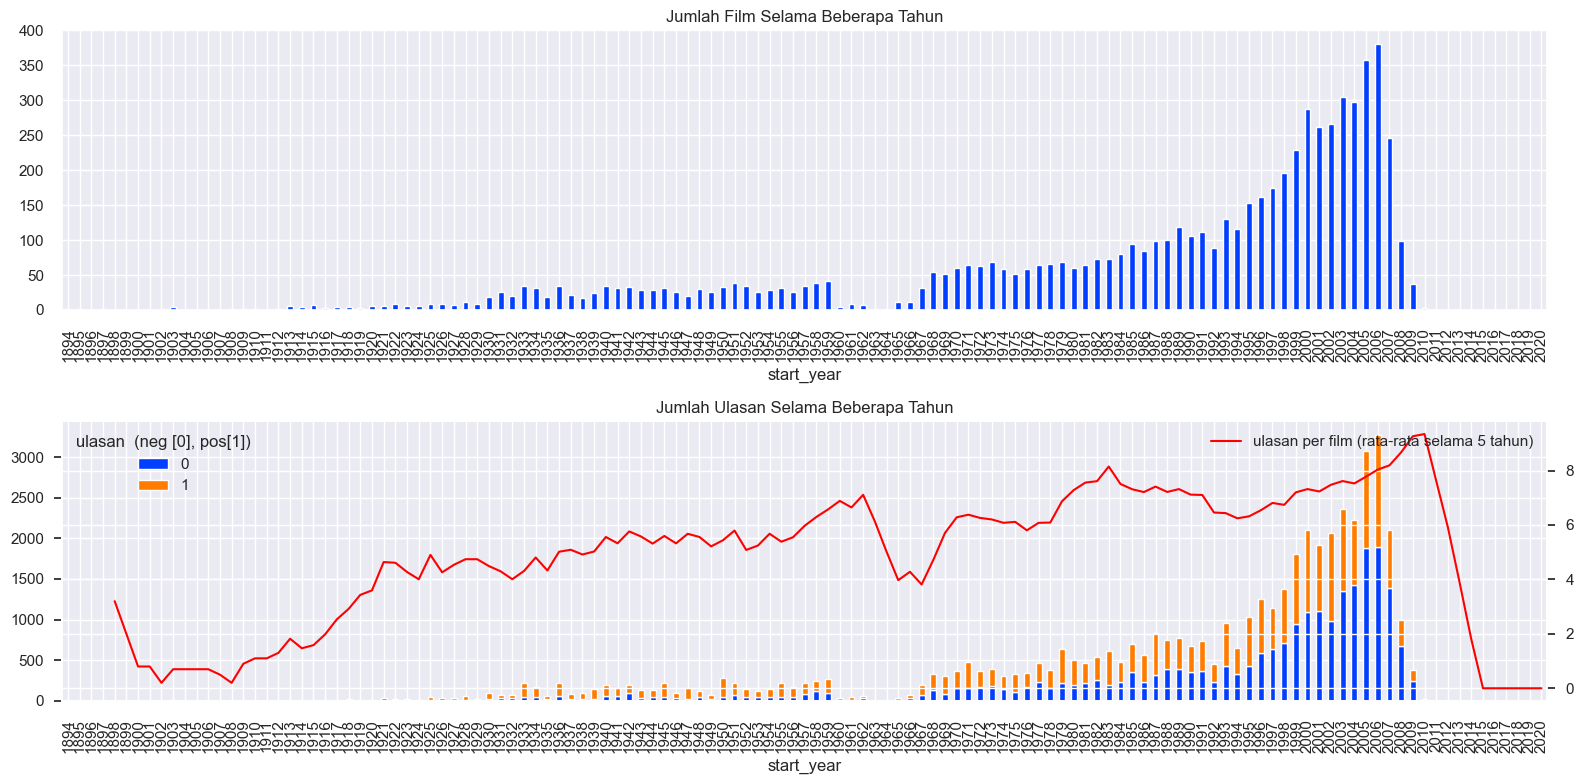

In [168]:
# membuat plot untuk distribusi jumlah film
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# plot untuk jumlah film
ax = axs[0]
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Beberapa Tahun')

# plot untuk jumlah ulasan (negatif dan positif)
ax = axs[1]
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2.rename_axis('ulasan  (neg [0], pos[1])',axis="columns",inplace=True)
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, ax=ax)

# plot jumlah rata-rata film untuk 5 tahunan
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='red', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)
plt.legend(loc="upper right")

ax.set_title('Jumlah Ulasan Selama Beberapa Tahun') 
fig.tight_layout()

Berdasarkan grafik diatas kita dapat menyimpulkan bahwa hampir `setiap tahun mengalami peningkatan jumlah film` yang diikuti dengan `meningkatnya jumlah ulasan` terhadap film tersebut dengan perbandingan `ulasan positif` dan `ulasan negatif` yang hampir `seimbang` hingga tahun `2006`. Jumlah ulasan rata-rata setiap `5 tahun` menunjukan `trend` yang `sedikit meningkat` dari tahun-tahun sebelumnya hingga puncak rata-rata tertinggi tahun `2010` lebih dari `3000 ulasan`.

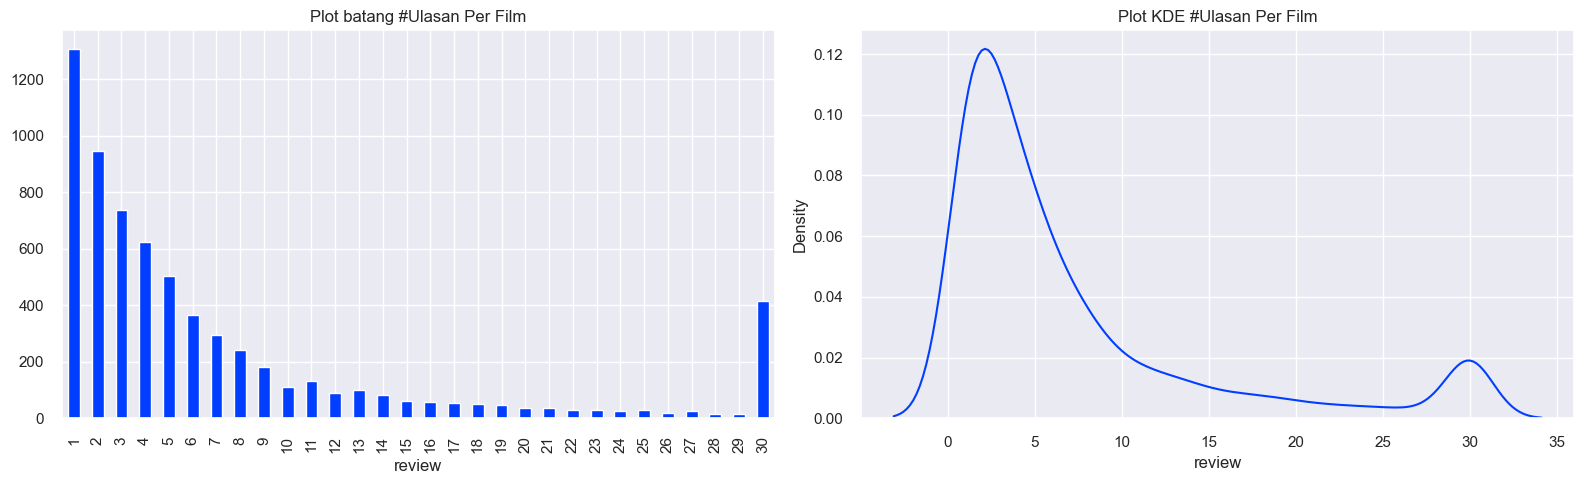

In [169]:
# membuat plot distribusi jumlah ulasan per film
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count().value_counts().sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film')
ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film') 

fig.tight_layout()

Berdasarkan grafik diatas rata-rata film kebanyakan memiliki ulasan sebanyak `1-5 ulasan/film`, kemudian diikuti dengan film yang memiliki ulasan sebanyak `30 ulasan/film` dan disusul setelahnya.

In [170]:
# menghitung keseimbangan kelas ulasan (negatif [0] dan positif[1])
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

Bisa kita lihat kita memiliki jumlah kelas yang hampir seimbang untuk model klasifikasi dengan `ulasan negatif [0]` dan `ulasan negatif [1]`.

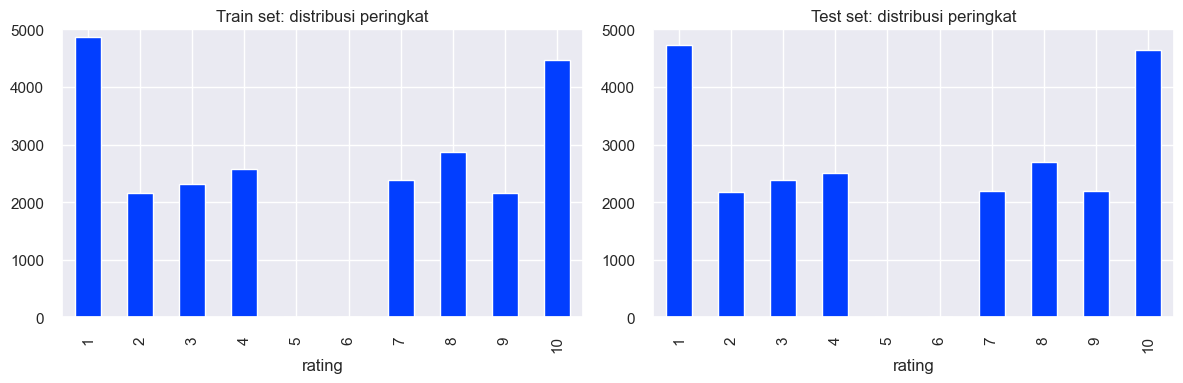

In [171]:
# membuat plot distribusi rating pada dataset training dan dataset test
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: distribusi peringkat')

fig.tight_layout()

Disini kita juga bisa melihat perbadingan jumlah `rating film` yang seimbang, baik untuk dataset `training` maupun dataset `test`. Bisa terlihat jumlah rating terbanyak adalah `1 dan 10` untuk kedua dataset.

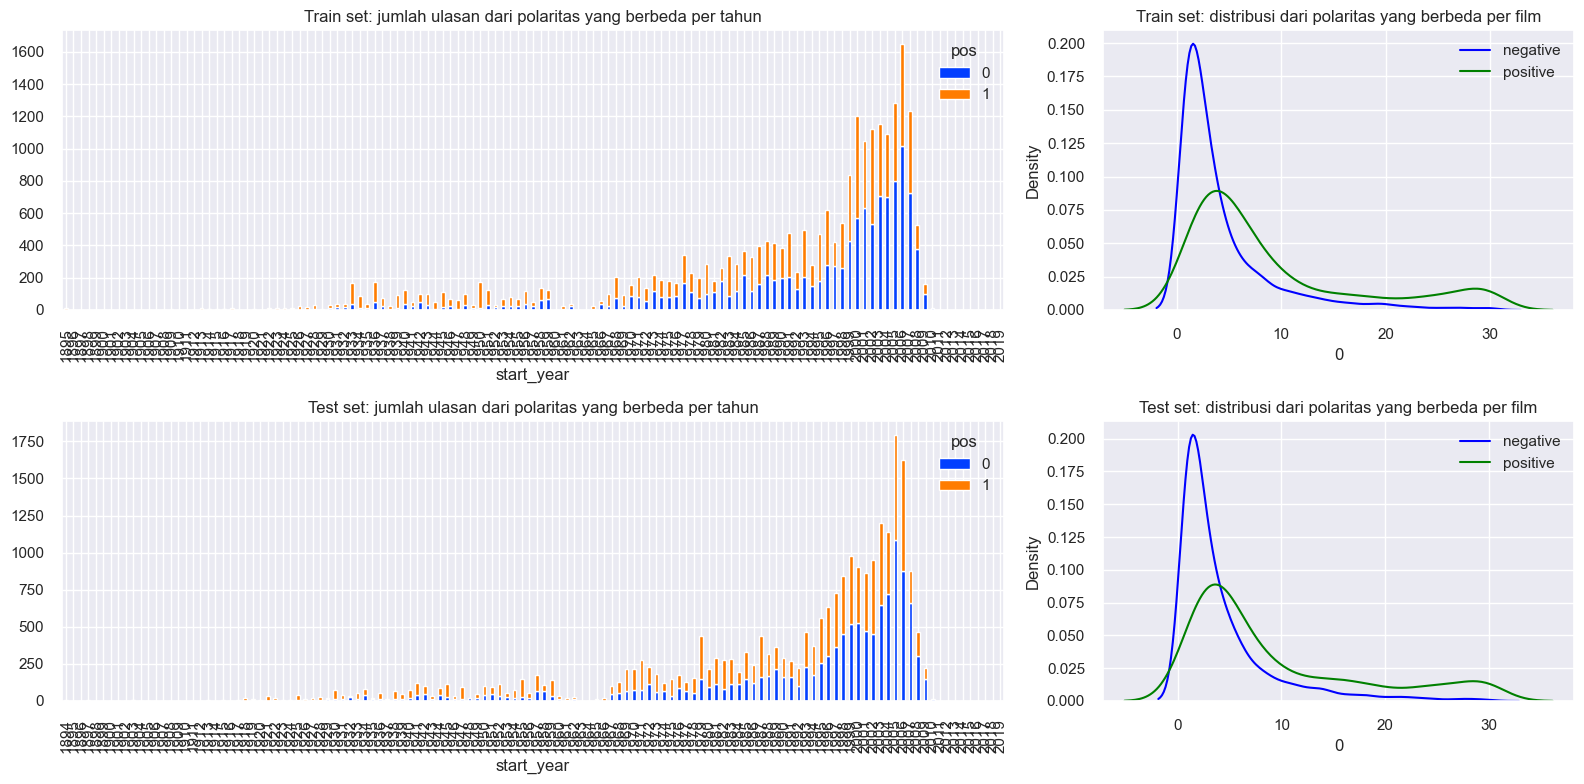

In [172]:
# membuat plot komparasi jumlah ulasan (negatif [0] dan positif[1]) berdasarkan dataset training dan test
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train set: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('Train set: distribusi dari polaritas yang berbeda per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('Test set: distribusi dari polaritas yang berbeda per film')

fig.tight_layout()

Disini bisa kita lihat bentuk dataset `training` dan `test` memiliki kemiripan berdasarkan jumlah `ulasan positif` dan jumlah `ulasan negatif`. Perbandingan jumlah ulasan `positif` dan jumlah ulasan `negatif` yang hampir seimbang untuk masing-masing dataset. Hal tersebut kita bisa langsung menggunakan dataset ini sebagai model latih dan uji pada model-model yang akan kita gunakan tanpa perlu adanya `filtering data`.

## Prosedur Evaluasi <a id='cont_4'></a>

Disini kita akan melakukan evaluasi model terhadap metrik-metrik yang akan kita amati diantaranya: `Akurasi`, `F1 Score`, `Average Precision Score (APS)`, `Area Under the Receiver Operating Characteristic Curve (AUC-ROC)`. Selain itu kita akan melihat kurva dari masing-masing skor, khusus untuk metrik `F1`, `APS` dan `AUC-ROC` serta menghitungnya berdasarkan `threshold`nya.

In [173]:
# menambahkan modul metrik
import sklearn.metrics as metrics

In [174]:
# membuat evaluasi model berdasarkan metrik skor dan grafik skor
def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        eval_stats[type] = {}
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return df_eval_stats

## Normalisasi <a id='cont_5'></a>

Kita menganggap semua model menerima teks dalam huruf kecil dan tanpa angka, tanda baca, dll. Kita akan melakukan normaliasi tersebut seperti berikut:

In [175]:
# sampel sebelum dilakukan normalisasi
df_reviews['review'][1]

'How the hell did they get this made?! Presenting itself as a caper comedy, the misbegotten "$" is essentially two hours of people mumbling sentence fragments. The usually dependable Warren Beatty looks drunk, and the usually hilarious Goldie Hawn acts like she\'s on depressants. As for Gert Frobe, his most famous role - Goldfinger - was infinitely more admirable than his character here. Not even the guy with the champagne bottle of LSD can save this litany of worthlessness. Am I comparing this movie to "Plan 9 from Outer Space"? I wouldn\'t do such a thing even if someone paid me. "P9FOS" was idiotically made but ended up hilarious; this was idiotically made and causes you to feel like your brain just melted out of your ears. Warren Beatty and Goldie Hawn made up for this when they co-starred in "Shampoo", but then they co-starred in the dreadful "Town & Country". Maybe they just shouldn\'t co-star in movies. All in all, I would rather have my skin torn off than have to watch this aga

In [176]:
# mendefinisikan fungsi untuk menghilangkan angka, tanda baca dan sebagainya
def pre_text(text):
    # mengecilkan huruf dari masing-masing kata
    text = text.lower()
    # mengekstrak kata dengan menghilangkan angka dan tanda baca
    pattern = r"[^a-z\s]"
    text = re.sub(pattern, " ", text)
    text = text.split()
    return ' '.join(text)

# menerapkan fungsi yang sudah dibuat
df_reviews['review_norm'] = df_reviews['review'].apply(pre_text)

In [177]:
# sampel setelah dilakukan normalisasi
df_reviews['review_norm'][1]

'how the hell did they get this made presenting itself as a caper comedy the misbegotten is essentially two hours of people mumbling sentence fragments the usually dependable warren beatty looks drunk and the usually hilarious goldie hawn acts like she s on depressants as for gert frobe his most famous role goldfinger was infinitely more admirable than his character here not even the guy with the champagne bottle of lsd can save this litany of worthlessness am i comparing this movie to plan from outer space i wouldn t do such a thing even if someone paid me p fos was idiotically made but ended up hilarious this was idiotically made and causes you to feel like your brain just melted out of your ears warren beatty and goldie hawn made up for this when they co starred in shampoo but then they co starred in the dreadful town country maybe they just shouldn t co star in movies all in all i would rather have my skin torn off than have to watch this again awful maybe they should remake it wit

Fungsi `pre_text` sudah bisa melakukan tugasnya untuk mengecilkan semua huruf serta membuang angka, tanda baca dan lain sebagainya kecuali `huruf` dan `tanda spasi`.

## Pemisahan Train / Test <a id='cont_6'></a>

Mari kita pisahkan dataset utama menjadi dataset khusus untuk `train` dan `test` dengan memanfaatkan kolom `ds_part` pada dataset utama.

In [178]:
# memfilter dataset menjadi train dan test
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# memisahkan target dari dataset
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [179]:
# mengecek keseimbangkan kelas pada data train
train_target.value_counts()

pos
0    11912
1    11884
Name: count, dtype: int64

In [180]:
# mengecek keseimbangkan kelas pada data test
test_target.value_counts()

pos
0    11803
1    11732
Name: count, dtype: int64

In [181]:
# memisahkan fitur
X_train = df_reviews_train['review_norm']
X_test = df_reviews_test['review_norm']

Semua dataset sudah berhasil dipisahkan menjadi `train` dan `test`. Kemudian masing-masing dataset sudah dipisahkan menjadi `fitur` dan `target` dengan jumlah kelas `ulasan` yang hampir seimbang. Selanjutnya bisa kita proses lebih lanjut.

## Bekerja dengan Model <a id='cont_7'></a>

Disini kita akan menguji beberapa model beserta pra-pemrosesan kata pada dataset. Beberapa model beserta pra-pemrosesanya:
1. Model-0: Model ini menggunakan `DummyClassifier` dan tanpa pra-pemrosesan dataset.
2. Model-1: Model ini menggunakan `LogisticRegression` dengan pra-pemrosesan lematisasi,stopwords dari NLTK dan vektorisasi TF-IDF.
3. Model-2: Model ini menggunakan `LogisticRegression` dengan pra-pemrosesan lematisasi,stopwords dari spaCy dan vektorisasi TF-IDF.
4. Model-3: Model ini menggunakan `LightGBM` dengan pra-pemrosesan lematisasi,stopwords dari spaCy dan vektorisasi TF-IDF.
5. Model-5: Model ini menggunakan `LogisticRegression` dengan pra-pemrosesan menggunakan BERT.

### Model 0 - Konstan <a id='cont_8'></a>

Model ini berasal dari `scikit-learn` dimana cara kerjanya hanya menghitung `output` tanpa dipengaruhi oleh `input`. Jika dominan `output` mendominasi, maka hasil prediksi semuanya akan bernilai dominan `output` tersebut.

In [182]:
# memuat modul dummyclassifier
from sklearn.dummy import DummyClassifier

In [183]:
# melatih model dummyclassifier
model_0 = DummyClassifier(strategy='most_frequent')
model_0.fit(X_train,train_target)

DummyClassifier(strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


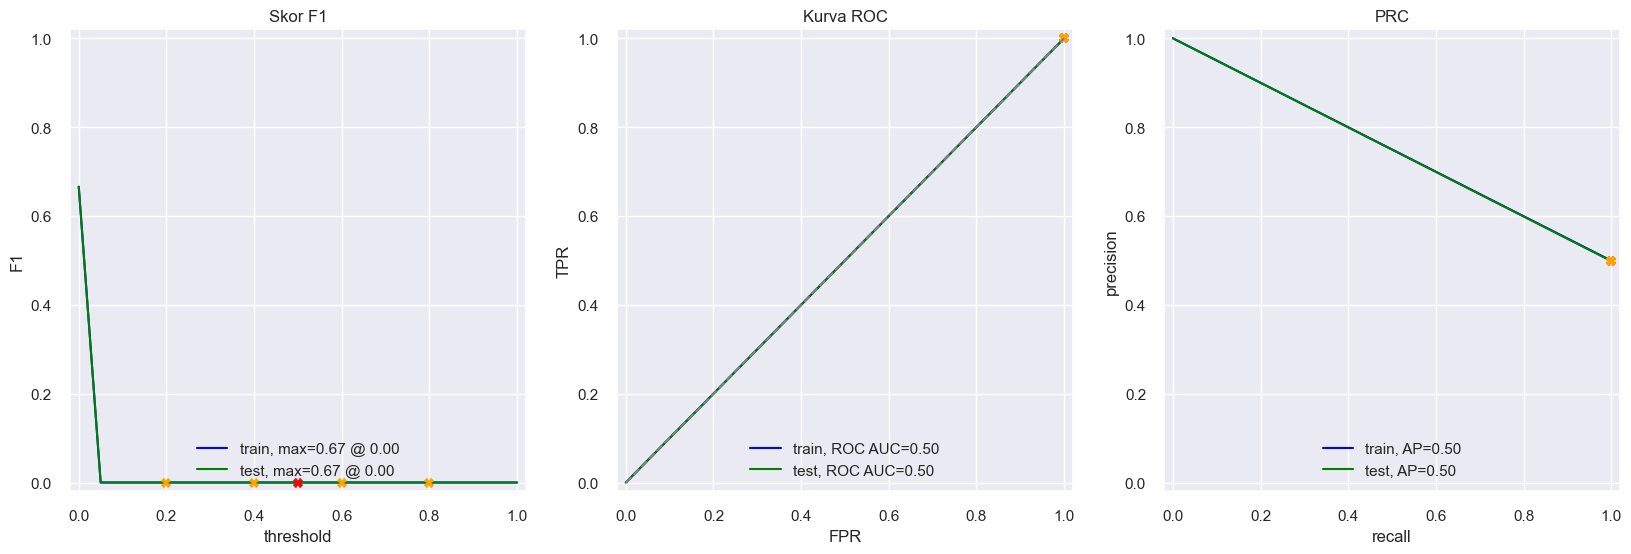

In [184]:
# mengevaluasi model-0 dummyclassifier
eval_0 = evaluate_model(model_0, X_train, train_target, X_test, test_target)

Bisa terlihat hampir semua skor untuk data test menunjukan angka `0.5` kecuali `F1 skor`. Model ini menunjukan model yang kurang baik dalam hal prediksi.

### Model 1 - NLTK, TF-IDF dan LR <a id='cont_9'></a>

Model ini bekerja menggunakan teknik pemrosesan kata dari `NLTK` untuk menghilangkan `stopwords` dan juga melakukan `lematiasi` kata. Setelah pemrosesan, dilakukan vektorisasi menggunakan TF-IDF dari modul `scikit-learn`. Model dari modul yang sama `LogisticRegression` dilatih dan diuji kemudian dievaluasi.

In [185]:
# memuat beberapa modul untuk model-1
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fuada\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fuada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [186]:
# mendefinisikan stopwords dan lematizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# membuat pra-pemrosesan untuk model-1
def text_preprocessing_1(text):
    words = word_tokenize(text)                                 # tokenisasi teks
    words = [word for word in words if word not in stop_words]  # menghilangkan stop_words
    words = [lemmatizer.lemmatize(word) for word in words]      # melakukan lematisasi kata
    return ' '.join(words)

# mentransformasi dataset menggunakan fungsi pra-pemrosesan model-1
transformed_train_1 = X_train.apply(text_preprocessing_1)
transformed_test_1 = X_test.apply(text_preprocessing_1)

# melakukan vektoriasi fitur pada masing-masing dataset
tfidf_vectorizer_1 = TfidfVectorizer()
train_features_1 = tfidf_vectorizer_1.fit_transform(transformed_train_1)
test_features_1 = tfidf_vectorizer_1.transform(transformed_test_1)

# melatih model logistic regression
model_1 = LogisticRegression()
model_1.fit(train_features_1,train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


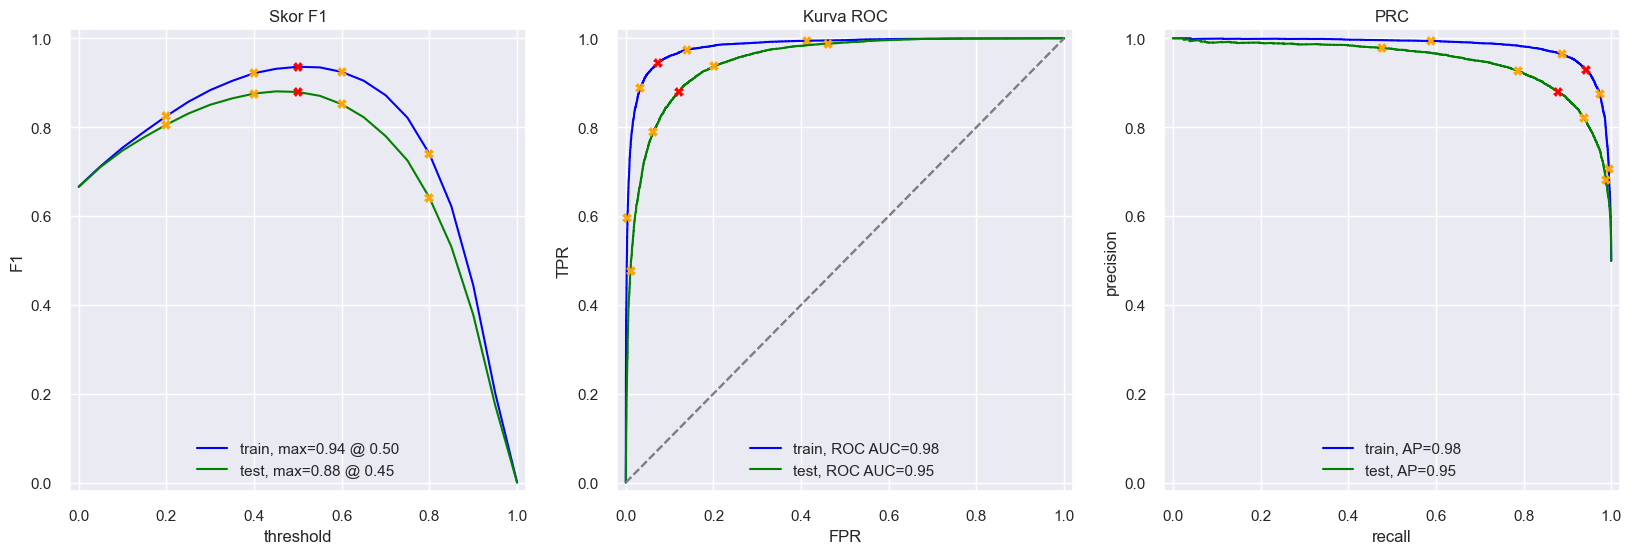

In [187]:
# mengevaluasi model-1 logistic regression
eval_1 = evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

Bisa kita lihat performa `model-1` ini semua skor untuk dataset `test` berkisar antara `0.88` hingga `0.95` menunjukan performa yang sangat bagus. Berdasarkan grafik, `model-1` tidak menunjukan adanya tanda-tanda `overfit` dikarenakan skor `train` dan `test` yang hampir seimbang.

### Model 2 - spaCy, TF-IDF dan LR <a id='cont_10'></a>

Model ini bekerja menggunakan teknik pemrosesan kata dari `spaCy` untuk menghilangkan `stopwords` dan juga melakukan `lematiasi` kata. Setelah pemrosesan, dilakukan vektorisasi menggunakan TF-IDF dari modul `scikit-learn`. Model dari modul yang sama `LogisticRegression` dilatih dan diuji kemudian dievaluasi.

In [188]:
# memuat modul spacy
import spacy

In [189]:
# mendefinisikan modul spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# membuat pra-pemrosesan untuk model-2
def text_preprocessing_2(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# mentransformasi dataset menggunakan fungsi pra-pemrosesan model-2
transformed_train_2 = X_train.apply(text_preprocessing_2)
transformed_test_2 = X_test.apply(text_preprocessing_2)

# melakukan vektoriasi fitur pada masing-masing dataset
tfidf_vectorizer_2 = TfidfVectorizer()
train_features_2 = tfidf_vectorizer_2.fit_transform(transformed_train_2)
test_features_2 = tfidf_vectorizer_2.transform(transformed_test_2)

In [190]:
# melatih model logistic regression
model_2 = LogisticRegression()
model_2.fit(train_features_2,train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


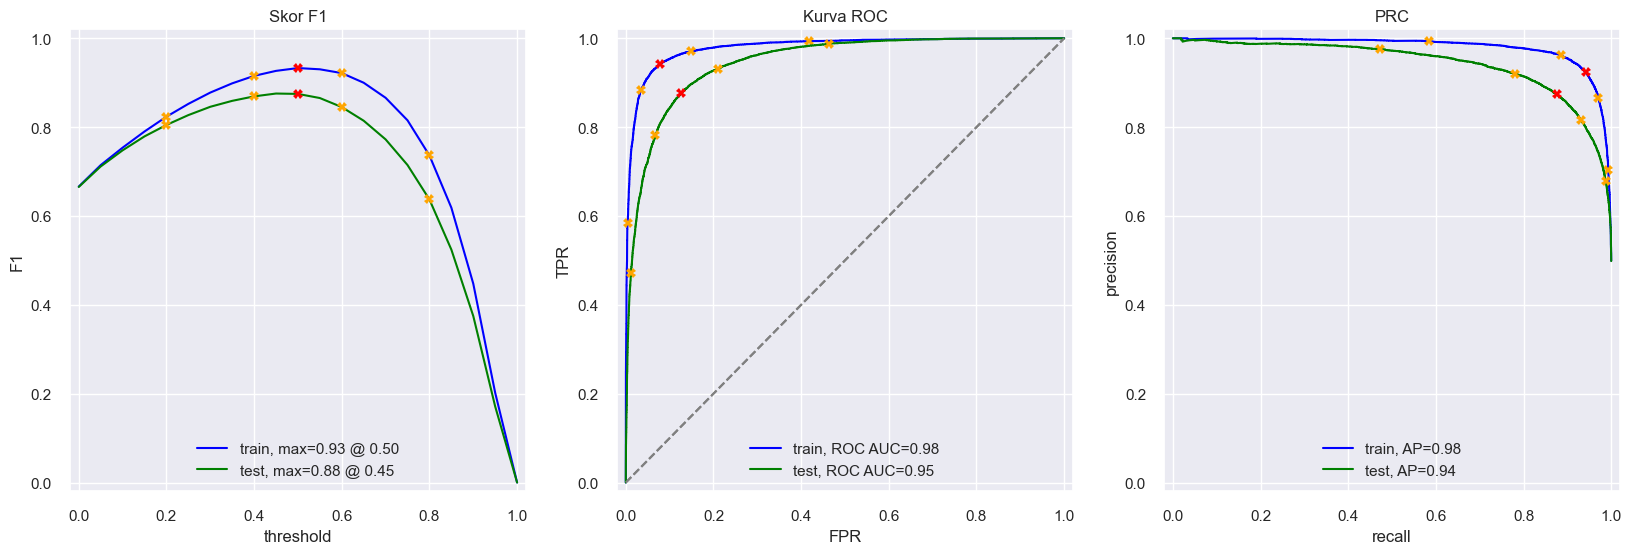

In [191]:
# mengevaluasi model-2 logistic regression
eval_2 = evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

Bisa kita lihat performa `model-2` ini semua skor untuk dataset `test` berkisar antara `0.87` hingga `0.95` menunjukan performa yang sangat bagus. Berdasarkan grafik, `model-2` tidak menunjukan adanya tanda-tanda `overfit` dikarenakan skor `train` dan `test` yang hampir seimbang.

### Model 3 - spaCy, TF-IDF dan LGBMClassifier <a id='cont_11'></a>

Sama seperti model-2 yang menggunakan teknik pemrosesan kata dari `spaCy` untuk menghilangkan `stopwords` dan juga melakukan `lematiasi` kata. Setelah pemrosesan, dilakukan vektorisasi menggunakan TF-IDF dari modul `scikit-learn`. Model yang digunakan berasal dari modul `LightGBM` menggunakan `LGBMClassifier` untuk dilatih dan diuji.

In [192]:
# memuat modul lgbm
from lightgbm import LGBMClassifier

In [193]:
# melatih model LGBMClassifier
model_3 = LGBMClassifier(learning_rate=0.2,n_estimators=250)
model_3.fit(train_features_2,train_target)

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.563463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 434948
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9268
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


LGBMClassifier(learning_rate=0.2, n_estimators=250)

          train  test
Accuracy    1.0  0.87
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.94


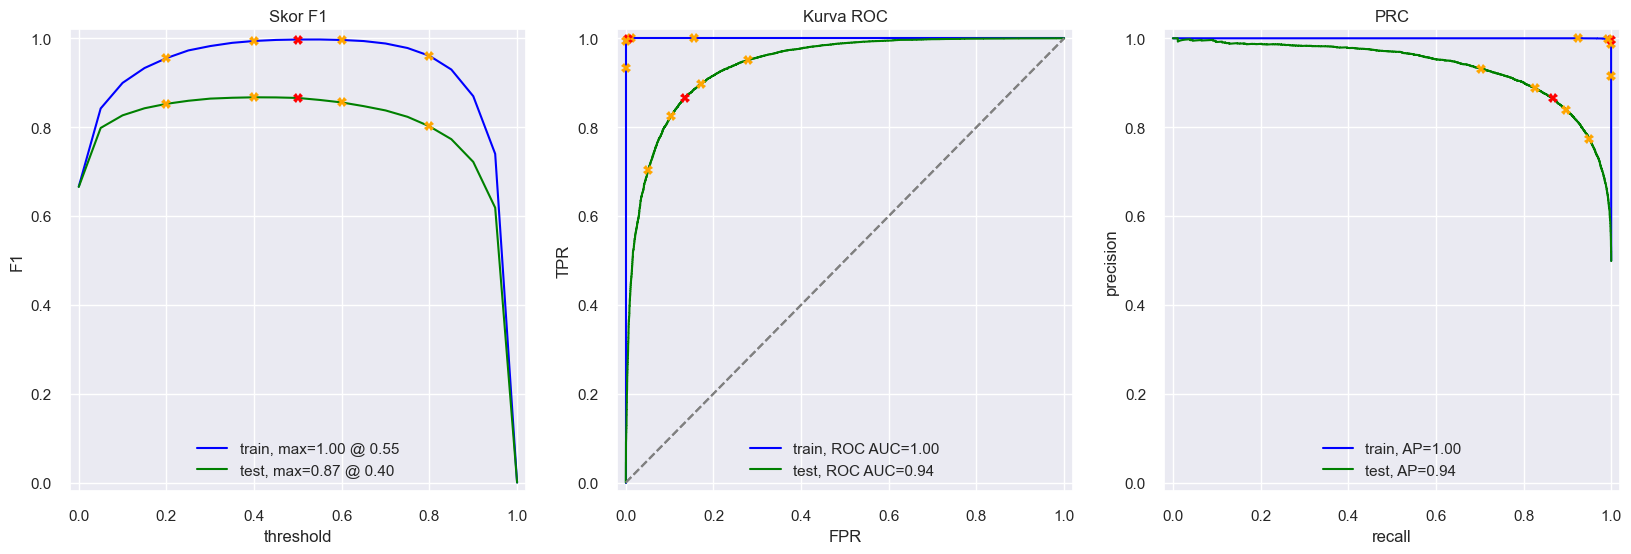

In [194]:
# mengevaluasi model-3 LGBMClassifier
eval_3 = evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

Bisa kita lihat performa `model-3` ini semua skor untuk dataset `test` berkisar antara `0.87` hingga `0.94` menunjukan performa yang sangat bagus. Berdasarkan grafik, `model-3` menunjukan adanya tanda-tanda `overfit` dikarenakan skor `train` dan `test` yang hampir tidak seimbang dimana skor untuk dataset `train` sempurna.

###  Model 4 - BERT (Bidirectional Encoder Representations from Transformers) dan LR <a id='cont_12'></a>

Berbeda dengan model-model sebelumnya, pada model ini menggunakan teknik `BERT` untuk memproses data serta menggunakan model `BERT` yang sudah dilatih untuk memproses kata. Model ini akan melakukan vektorisasi kata dengan melibatkan tetangga kanan dan kirinya dalam vektorisasinya yang menggunakan enkoder khusus yang ada pada modul `transformers`. Setelah prapemrosesan, dilanjutkan dengan melatih dan menguji model `LogisticRegression`. Model ini dipilih karena menghasilkan skor yang baik dan tidak terlalu `overfit`.

#### Jumlah Sampel Kecil <a id='cont_13'></a>

Disini kita akan melakukan pengetesan model dengan menggunakan sampel data yang sedikit dikarenakan waktu komputasi yang lama jika menggunakan dataset besar. Kita akan menggunakan `100 sampel` sebagai percobaan. Kita akan memastikan bahwa kelas pada dataset `training` dan `test` memiliki keseimbangan kelas.

In [195]:
# memuat modul untuk model BERT
import torch
import transformers
from sklearn.model_selection import train_test_split

In [196]:
# mendefinisikan model, config, tokenizer dan jumlah sampel
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')
max_sample_size = 100

In [197]:
# melakukan duplikasi dataset train
df_reviews_train = df_reviews_train.reset_index(drop=True).copy()
train_target = train_target.reset_index(drop=True).copy()

# membagi dataset training sebanyak 50 dengan proporsi kelas yang sama
df_reviews_train_1 = df_reviews_train[df_reviews_train['pos'] == 1]
df_reviews_train_0 = df_reviews_train[df_reviews_train['pos'] == 0]
train_bert = pd.concat([df_reviews_train_0[:int(max_sample_size/4)]['review_norm'],df_reviews_train_1[:int(max_sample_size/4)]['review_norm']],axis=0)
target_train_bert = df_reviews_train.iloc[train_bert.index].copy()
target_train_bert['pos'].value_counts()

pos
0    25
1    25
Name: count, dtype: int64

In [198]:
# melakukan duplikasi dataset test
df_reviews_test = df_reviews_test.reset_index(drop=True).copy()
test_target = test_target.reset_index(drop=True).copy()

# membagi dataset training sebanyak 50 dengan proporsi kelas yang sama
df_reviews_test_1 = df_reviews_test[df_reviews_test['pos'] == 1]
df_reviews_test_0 = df_reviews_test[df_reviews_test['pos'] == 0]
test_bert = pd.concat([df_reviews_test_0[:int(max_sample_size/4)]['review_norm'],df_reviews_test_1[:int(max_sample_size/4)]['review_norm']],axis=0)
target_test_bert = df_reviews_test.iloc[test_bert.index].copy()
target_test_bert['pos'].value_counts()

pos
0    25
1    25
Name: count, dtype: int64

Jumlah kelas ulasan untuk dataset training dan test sudah seimbang. Kita akan menggabungkan kedua dataset menjadi satu baik untuk `fitur` maupun `target`.

In [199]:
# menggabungkan dataset train dan test
features_bert = pd.concat([train_bert,test_bert],axis=0)
target_bert = pd.concat([target_train_bert['pos'],target_test_bert['pos']],axis=0)

print(features_bert.shape)
print(target_bert.shape)

(100,)
(100,)


Jumlah sudah sesuai dengan yang kita deskripsikan jumlah sampel diawal sebanyak `100 sampel`. Selanjutnya kita akan membuat fungsi untuk melakukan prapemrosesan kata menggunakan model `BERT`.

In [200]:
# mendefinisikan fungsi untuk memproses kata menggunakan BERT
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # teks ke id token yang sudah di-padded bersamaan dengan attention mask
    max_length = 512
    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Gunakan {device} perangkat.')
    
    # dapatkan embedding dalam batch 
    embeddings = []
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
    return np.concatenate(embeddings)

In [201]:
# Perhatian! Menjalankan BERT untuk ribuan teks mungkin memakan waktu lama di CPU, setidaknya beberapa jam
transformed_features_bert = BERT_text_to_embeddings(features_bert)

Gunakan cpu perangkat.


  0%|          | 0/1 [00:00<?, ?it/s]

In [202]:
# membagi dataset yang sudah dilakukan prapemrosesan menggunakan BERT menjadi train dan test dengan jumlah kelas ulasan yang seimbang
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(transformed_features_bert,target_bert,test_size=0.2,stratify=target_bert,random_state=42)

print(y_train_bert.value_counts())
print(y_test_bert.value_counts())

pos
0    40
1    40
Name: count, dtype: int64
pos
1    10
0    10
Name: count, dtype: int64


In [203]:
# melatih model logistic regression
model_4 = LogisticRegression()
model_4.fit(X_train_bert,y_train_bert)

LogisticRegression()

          train  test
Accuracy    1.0  0.85
F1          1.0  0.86
APS         1.0  0.90
ROC AUC     1.0  0.90


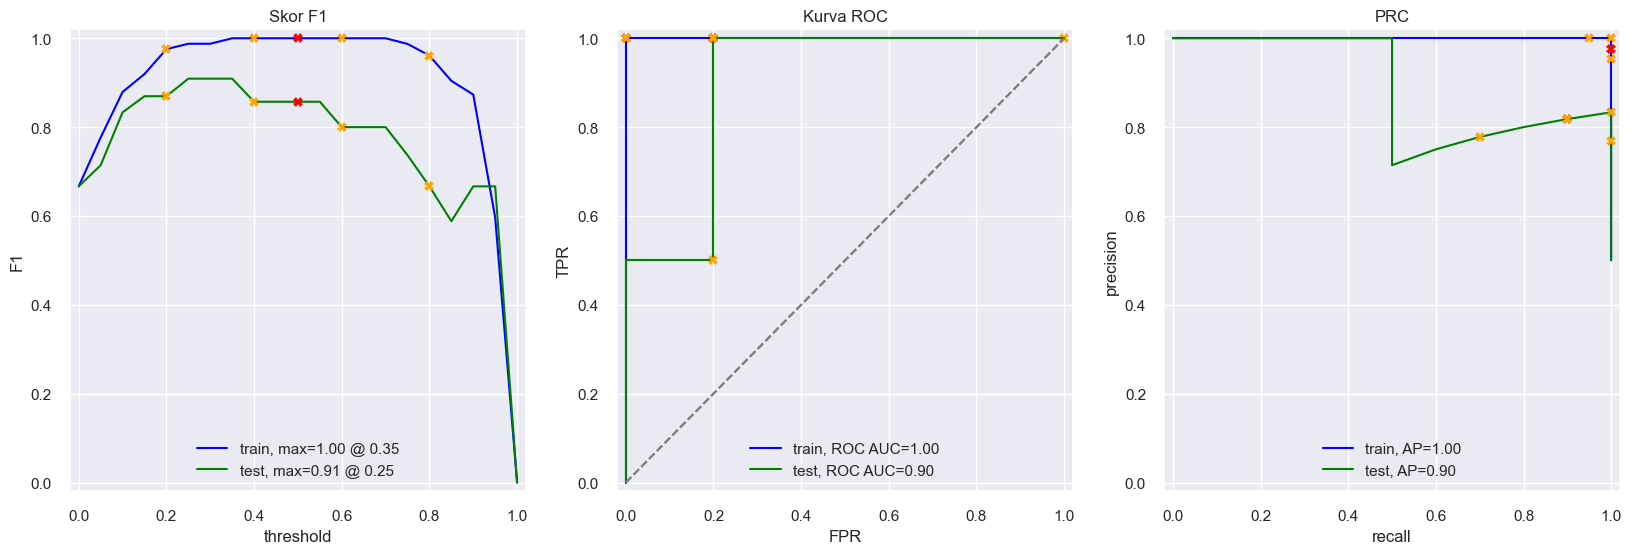

In [204]:
# mengevaluasi model-4 LogisticRegression
eval_4 = evaluate_model(model_4, X_train_bert, y_train_bert, X_test_bert, y_test_bert)

Bisa kita lihat performa `model-4` ini semua skor untuk dataset `test` berkisar antara `0.85` hingga `0.90` menunjukan performa yang sangat bagus. Berdasarkan grafik, `model-4` dengan jumlah sampel yang sedikit kurang baik dalam meberikan skor, bisa terlihat grafik skor yang tidak `smooth` dan juga menunjukan adanya tanda-tanda `overfit`.

#### Jumlah Sampel Besar <a id='cont_14'></a>

Selanjutnya kita akan memproses model BERT menggunakan sampel dalam jumlah besar. Jumlah sampel yang akan diproses berkisar `47199 sampel` atau hampir semua dataset. Dikarenakan waktu komputasi yang lama jika menggunakan laptop pribadi. Kita akan menggunakan fasilitas `GPU` dari `Google Colab` untuk memproses kata dan sudah mendapatkan hasilnya dalam bentuk file `features_4.npz`. Kita tinggal menjalankanya dan melatih model kita.

In [205]:
# jika sudah mendapatkan embedding, disarankan untuk menyimpannya agar siap 
# np.savez_compressed('features_4.npz', train_features=transformed_features_bert, test_features=test_target_bert)

# dan muat...
# with np.load('features_4.npz') as data:
#     transformed_features_bert = data['transformed_features_bert']
#     target_bert = data['target_bert']

In [206]:
# memuat hasil dari features_4.npz
with np.load('features_4.npz') as data:
    large_features_bert = data['train_features']
    large_target_bert = data['test_features']

print(large_features_bert.shape)
print(large_target_bert.shape)

(47199, 768)
(47199,)


In [207]:
# membagi dataset yang sudah dilakukan prapemrosesan menggunakan BERT menjadi train dan test dengan jumlah kelas ulasan yang seimbang
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(large_features_bert,large_target_bert,test_size=0.2,stratify=large_target_bert,random_state=42)

# melatih model logistic regression
model_5 = LogisticRegression()
model_5.fit(X_train_bert,y_train_bert)

c:\Users\fuada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

          train  test
Accuracy   0.87  0.86
F1         0.87  0.86
APS        0.94  0.94
ROC AUC    0.94  0.94


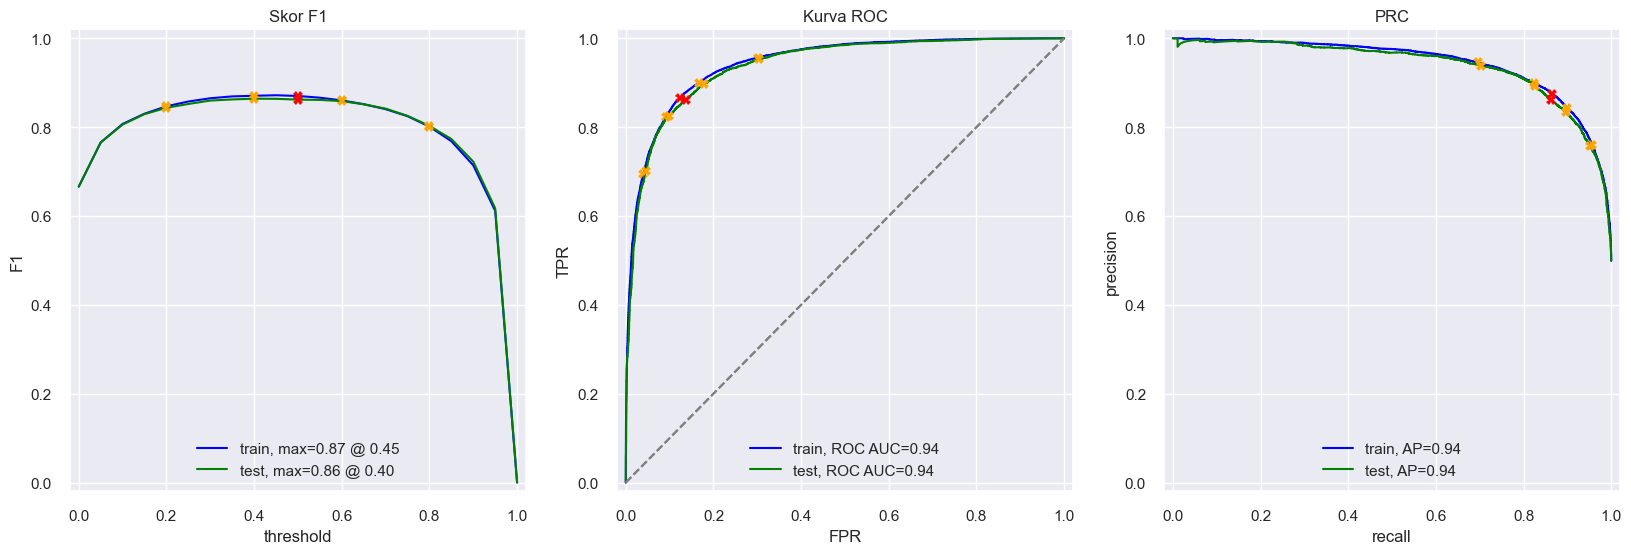

In [208]:
# mengevaluasi model-5 LogisticRegression
eval_5 = evaluate_model(model_5, X_train_bert, y_train_bert, X_test_bert, y_test_bert)

Bisa kita lihat performa `model-5` ini semua skor untuk dataset `test` berkisar antara `0.86` hingga `0.94` menunjukan performa yang sangat bagus. Berdasarkan grafik, `model-5` menunjukan tidak adanya tanda-tanda `overfit` dikarenakan skor `train` dan `test` yang hampir seimbang bahkan hampir sama.

In [209]:
# memfilter evaluasi test result pada model-0
model_0_acu = eval_0.iloc[0]['test']
model_0_f1 = eval_0.iloc[1]['test']
model_0_APS = eval_0.iloc[2]['test']
model_0_ROC_AUC = eval_0.iloc[3]['test']

# memfilter evaluasi test result pada model-1
model_1_acu = eval_1.iloc[0]['test']
model_1_f1 = eval_1.iloc[1]['test']
model_1_APS = eval_1.iloc[2]['test']
model_1_ROC_AUC = eval_1.iloc[3]['test']

# memfilter evaluasi test result pada model-2
model_2_acu = eval_2.iloc[0]['test']
model_2_f1 = eval_2.iloc[1]['test']
model_2_APS = eval_2.iloc[2]['test']
model_2_ROC_AUC = eval_2.iloc[3]['test']

# memfilter evaluasi test result pada model-3
model_3_acu = eval_3.iloc[0]['test']
model_3_f1 = eval_3.iloc[1]['test']
model_3_APS = eval_3.iloc[2]['test']
model_3_ROC_AUC = eval_3.iloc[3]['test']

# memfilter evaluasi test result pada model-5
model_5_acu = eval_5.iloc[0]['test']
model_5_f1 = eval_5.iloc[1]['test']
model_5_APS = eval_5.iloc[2]['test']
model_5_ROC_AUC = eval_5.iloc[3]['test']

In [210]:
# membuat tabel komparasi
table_comp = pd.DataFrame(data = {
    'model' : ['model-0','model-1','model-2','model-3','model-5'],
    'Accuracy': [model_0_acu,model_1_acu,model_2_acu,model_3_acu,model_5_acu],
    'F1 ': [model_0_f1,model_1_f1,model_2_f1,model_3_f1,model_5_f1],
    'APS': [model_0_APS,model_1_APS,model_2_APS,model_3_APS,model_5_APS],
    'ROC AUC': [model_0_ROC_AUC,model_1_ROC_AUC,model_2_ROC_AUC,model_3_ROC_AUC,model_5_ROC_AUC]
}, index=['Dummy','NLTK_TFIDF_LR','spaCy_TFIDF_LR','spaCy_TFIDF_LGBM','BERT_LR'])

# menampilkan tabel komparasi
table_comp

,model,Accuracy,F1,APS,ROC AUC
Dummy,model-0,0.50,0.00,0.50,0.50
NLTK_TFIDF_LR,model-1,0.88,0.88,0.95,0.95
spaCy_TFIDF_LR,model-2,0.87,0.87,0.94,0.95
spaCy_TFIDF_LGBM,model-3,0.87,0.87,0.94,0.94
BERT_LR,model-5,0.86,0.86,0.94,0.94


Bisa kita simpulkan bahwa beberapa model yang kita latih dan uji lolos terhadap skor yang kita tetapkan yaitu `F1 >= 0.85`. Model-model yang lolos diantaranya `model-1`, `model-2`, `model-3` dan `model-5`. Jika model kita urutkan dari yang terbaik menuju yang terbaik dengan mempertimbangkan skor dan adanya tanda-tanda overfit: `model-1` > `model-2` > `model-5` > `model-3`.

## Ulasan Khusus <a id='cont_15'></a>

Disini kita akan mencoba melakukan pengujian terhadap model-model yang sudah kita buat dan sudah dilatih menggunakan ulasan yang dibuat secara manual untuk mengidentifikasi apakah ulasan ini `positif` atau `negatif`.

In [211]:
# ulasan yang dibuat
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# melakukan normalisasi teks
my_reviews['review_norm'] = my_reviews['review'].apply(pre_text)
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


Kita bisa simpulkan ulasan bernilai `positif` terdapat pada `indeks [2,4,7]` sedangkan ulasan `negatif` terdapat pada `indeks [0,1,3,6]`. Kita akan membuat `threshold` sebesar `0.5` sebagai pembatas antara ulasan `positif` dan ulasan `negatif`. 

### Model 1 <a id='cont_16'></a>

In [212]:
# pengujian pada model-1
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i did not simply like it not my kind of movie
0.19:  well i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.39:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Berdasarkan prediksi model-1 dapat kita simpulkan bahwa ulasan `positif` dengan mempertimbangkan `threshold` terdapat pada `index [2,7]` sedangkan ulasan `negatif` pada `indeks [0,1,3,4,5,6]`. Model ini benar 7 dan salah 1.

### Model 2 <a id='cont_17'></a>

In [213]:
# pengujian pada model-2
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.52:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i didn t expect the reboot to be so good writers really cared about the source material
0.41:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Berdasarkan prediksi model-2 dapat kita simpulkan bahwa ulasan `positif` dengan mempertimbangkan `threshold` terdapat pada `index [2,7]` sedangkan ulasan `negatif` pada `indeks [0,1,3,4,5,6]`.  Model ini benar 7 dan salah 1.

### Model 3 <a id='cont_18'></a>

In [214]:
# pengujian pada model-3
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.51:  i did not simply like it not my kind of movie
0.11:  well i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.18:  i didn t expect the reboot to be so good writers really cared about the source material
0.72:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.95:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Berdasarkan prediksi model-3 dapat kita simpulkan bahwa ulasan `positif` dengan mempertimbangkan `threshold` terdapat pada `index [0,2,5,7]` sedangkan ulasan `negatif` pada `indeks [1,3,4,6]`.  Model ini benar 5 dan salah 3.

### Model 5 <a id='cont_19'></a>

In [215]:
# pengujian pada model-5
texts = my_reviews['review_norm']
my_reviews_features_4 = BERT_text_to_embeddings(texts, disable_progress_bar=True)
my_reviews_pred_prob = model_5.predict_proba(my_reviews_features_4)[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.01:  well i was bored and felt asleep in the middle of the movie
0.99:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didn t expect the reboot to be so good writers really cared about the source material
0.94:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.96:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Berdasarkan prediksi model-5 dapat kita simpulkan bahwa ulasan `positif` dengan mempertimbangkan `threshold` terdapat pada `index [2,5,7]` sedangkan ulasan `negatif` pada `indeks [0,1,3,4,6]`.  Model ini benar 6 dan salah 2.

Berdasarkan ini, menunjukan bahwa `model-1` memberikan hasil prediksi paling baik dimana `benar 7` dan `salah 1`. Jika kita turunkan `threshold` menjadi `0,4`, maka `model-1` akan memberikan `jawaban benar semua`. 

## Kesimpulan <a id='cont_20'></a>

Pada projek ini kita sudah belajar melakukan `pengecekan dataset`, `EDA`, `pra-pemrosesan kata`, `vektorisasi kata`, melakukan `pelatihan model`, dan `evaluasi model`. Semua  proses berjalan dengan baik, data `tidak memiliki duplikasi`, data memiliki `nilai yang hilang bisa diabaikan`, jumlah kelas `ulasan positif` dan `negatif seimbang`, dan juga jumlah dataset `train` dan `test` seimbang. Ada beberapa kesimpulan yang bisa kita dapatkan dari projek ini:
- Hampir `setiap tahun mengalami peningkatan jumlah film` yang diikuti dengan `meningkatnya jumlah ulasan` terhadap film tersebut dengan perbandingan `ulasan positif` dan `ulasan negatif` yang hampir `seimbang` hingga tahun `2006`. Jumlah ulasan rata-rata setiap `5 tahun` menunjukan `trend` yang `sedikit meningkat` dari tahun-tahun sebelumnya hingga puncak rata-rata tertinggi tahun `2010` lebih dari `3000 ulasan`.
- Rata-rata film kebanyakan memiliki ulasan sebanyak `1-5 ulasan/film`, kemudian diikuti dengan film yang memiliki ulasan sebanyak `30 ulasan/film` dan disusul setelahnya.
- Perbadingan jumlah `rating film` yang seimbang, baik untuk dataset `training` maupun dataset `test` dengan jumlah rating terbanyak adalah `1 dan 10` untuk kedua dataset.
- Bentuk dataset `training` dan `test` memiliki kemiripan berdasarkan jumlah `ulasan positif` dan jumlah `ulasan negatif`. Perbandingan jumlah ulasan `positif` dan jumlah ulasan `negatif` yang hampir seimbang untuk masing-masing dataset.
- Beberapa model yang kita latih dan uji lolos terhadap skor yang kita tetapkan yaitu `F1 >= 0.85`. Model-model yang lolos diantaranya `model-1`, `model-2`, `model-3` dan `model-5`. Jika model kita urutkan dari yang terbaik menuju yang terbaik dengan mempertimbangkan skor dan adanya tanda-tanda overfit: `model-1` > `model-2` > `model-5` > `model-3`.
- Pada sub-bab `Ulasan Khusus` menunjukan bahwa `model-1` memberikan hasil prediksi paling baik dimana `benar 7` dan `salah 1`. Jika kita turunkan `threshold` menjadi `0,4`, maka `model-1` akan memberikan `jawaban benar semua`. 